In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import HOSVD, HOOI
from coursework.data import get_image, plot_tensors                                       

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (3, 4, 5)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
elements_fmat = 0
for mode, fmat in enumerate(tensor_tkd.fmat):
    elements_fmat += fmat.size
    
print('\nNumber of elements in Tucker form =',elements_fmat+tensor_tkd.core.size)
print('\nNumber of elements of original tensor = ', tensor.size)

Tucker representation of a tensor with multi-linear rank=(3, 4, 5).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 3)
Mode-1 factor matrix is of shape (6, 4)
Mode-2 factor matrix is of shape (7, 5)

Number of elements in Tucker form = 134

Number of elements of original tensor =  210


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor - Tensor difference between the estimation and true tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation - We use Frobenious norm as cost function
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.3368228641783777


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor
I, J, K, L = 2, 3, 5, 7
array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_4d)
# Result preview
print(tensor)

This tensor is of order 4 and consists of 210 elements.
Sizes and names of its modes are (2, 3, 5, 7) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [7]:
# Perform decomposition

# Initialise algorithm
algorithm = HOOI()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(2, 3, 5, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (2, 3, 5, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2, 2)
Mode-1 factor matrix is of shape (3, 3)
Mode-2 factor matrix is of shape (5, 5)
Mode-3 factor matrix is of shape (7, 2)

	Core tensor
This tensor is of order 4 and consists of 60 elements.
Sizes and names of its modes are (2, 3, 5, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [8]:
# Print ratio

# Compute residual tensor - Tensor difference between the estimation and true tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation - We use Frobenious norm as cost function
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
print("\nCalculating ratio between number of elements in the original tensor and its Tucker form:")
print("1) Number of elements of original tensor = ", tensor.size)
print("2) Number of elements of Tucker core tensor = ", tensor_tkd.core.size)
ratio_elements = tensor.size / tensor_tkd.core.size
print("\t Ratio of elements between original tensor and its Tucker core tensor = ",ratio_elements)

elements_fmat = 0
for mode, fmat in enumerate(tensor_tkd.fmat):
    elements_fmat += fmat.size
    
print("3) Number of elements of all Factor matrices = ", elements_fmat)
tucker_elements = elements_fmat+tensor_tkd.core.size
print("4) Total Number of elements of Tucker form = ", tucker_elements)
print("\t Ratio of elements between original tensor and its Tucker form = ",tensor.size / tucker_elements)
print("\t Therefore, t original tensor is compressed by", tensor.size / tucker_elements, "times.")

Relative error of approximation = 0.38871898964218055

Calculating ratio between number of elements in the original tensor and its Tucker form:
1) Number of elements of original tensor =  210
2) Number of elements of Tucker core tensor =  60
	 Ratio of elements between original tensor and its Tucker core tensor =  3.5
3) Number of elements of all Factor matrices =  52
4) Total Number of elements of Tucker form =  112
	 Ratio of elements between original tensor and its Tucker form =  1.875
	 Therefore, t original tensor is compressed by 1.875 times.


### Solution: Part 2

For a tensor $\mathbf{X}$ to consist of 1331 elements, then the product of its dimensions must equal 1331. By denoting the dimension across n mode of the $N^{th}$-order tensor as $I_{n}$, then it means that $1331 = \prod^{N}_{n=1}I_{n}$. In order to identify the maximum order of core tensor, we consider the prime factorization of number 1331, which is equal to: 1331=11x11x11. Since the number of prime factors is 3, it means that the tensor order should be at maximum 3 to be represented by Tucker form. For perfect reconstruction of tensor $\mathbf{X}$ from its Tucker form, the core tensor $\mathbf{G} \in \mathbb{R}^{R_{1}\times R_{2} \times \dots \times R_{N}}$ must have the same dimensions in each mode as original tensor $\mathbf{X}$ in order for the Tucker decomposition equation to be an exact equality. This effectively means that for all modes $n = 1, 2, \dots , N$, the core tensor dimensions $R_{n}=I_{n}$, i.e. setting dimensions of core tensor equal to the full rank (upper limit rank) of original tensor. For perfect reconstruction, the Tucker equation is an equality and not an approximation, which means that $rank_{ML}(\mathbf{X}) = \{rank(\mathbf{X}_{(1)}), rank(\mathbf{X}_{(2)}),...,rank(\mathbf{X}_{(N)})\}$, where $\mathbf{X}_{(n)}$ denoted the n-mode unfolding of tensor $\mathbf{X}$. Since the rank in each n-mode unfolding of $\mathbf{X}$ is $I_{n}$, then this means $R_{n} = rank(\mathbf{X}_{n}) = I_{n}$. Note that $\mathbf{X}_{(n)}$ is a matrix with $I_{n}$ rows and $I_{1}\times \dots \times I_{n-1} \times I_{n+1} \times dots I_{N}$ columns, so rank is $I_{n}$, due to $I_{n}$ linearly independent rows.

The multi-linear rank of tensor $\mathbf{X}$ is the $N$-tuple $(R_1, \dots, R_N)$. If we set the order of tensor $\mathbf{X}$ equal to 2, where tensor is effectively a matrix, then its multi-linear rank is $(R_1, R_2)$. In order to have 1331 elements in tensor $\mathbf{X}$, then $R_{1}R_{2}=1331$, however for matrices the equality $R_{1}=R_{2}$ must always hold, according to the Note . Since there are no values of $R_{1}$ and $R_{2}$ that are equal and have a product of 1331 (only combinations of 11 and 121 have product of 1331), then tensor can not be order 2. Also if original tensor is order 1, i.e. a vector, then its rank is also 1 and there is no Tucker decomposition for tensors of rank 1. This can also be seen by treating a vector as a matrix with dimensions ($I_{n} \times 1$), so for perfect reconstruction $R_{1}=R_{2}$ must always hold, which is never true for vectors. Thefore tensor must be of order 3. This effectively means that the multi-linear rank of order-3 tensor with 1331 elements is $(R_1, R_2, R_3) = (11, 11, 11)$, which is the only possible combination of $R_{1}, R_{2}$ and $R_{3}$ values that give rise to 1331 elements. 

The purpose of Tucker decomposition is to represent tensors with fewer parameters (lower number of elements), to reduce computational cost and memory storage required, and obtain an approximation to the original tensor, with low residual error. However, the choice of having the multi-linear rank of tensor $\mathbf{X}$ equal to $(11,11,11)$, means that the decomposition retains all data stored in tensor $\mathbf{X}$ resulting in no compression of data and thus no dimensionality reduction. Additionally, as shown by the illustration below, although the error is effectively zero, the number of elements using this multi-linear rank causes the number of elements of Tucker representation to be greater than the elements of original tensor. This makes the Tucker decomposition method not suitable for practical applications, as the original tensor can be chosen instead with lower number of elements (lower computational complexity). For this reason in practical applications we can allow for some approximation error, by having $R_{n}\ll I_{n}$, to obtain in return data compression.

In [9]:
# Illustration below

# Create a tensor
I, J, K = 11, 11,11
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Perform decomposition
# Initialise algorithm
algorithm = HOOI()
# Perform decomposing for selected multi-linear rank
ml_rank = (11, 11, 11)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
print(tensor_tkd)

# Compute residual tensor - Tensor difference between the estimation and true tensor
tensor_res = residual_tensor(tensor, tensor_tkd)
# Compute error of approximation - We use Frobenious norm as cost function
print("Relative error of approximation = {}".format(tensor_res.frob_norm / tensor.frob_norm))

# Calculating number of elements of Original Tensor and Tucker representation
elements_fmat = 0
for mode, fmat in enumerate(tensor_tkd.fmat):
    elements_fmat += fmat.size
tucker_elements = elements_fmat+tensor_tkd.core.size
print("\nTotal Number of elements of Tucker form = ", tucker_elements)
print("Number of elements of original tensor = ", tensor.size)

Tucker representation of a tensor with multi-linear rank=(11, 11, 11).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (11, 11, 11) features respectively.
Relative error of approximation = 1.0937599899141927e-15

Total Number of elements of Tucker form =  1694
Number of elements of original tensor =  1331


# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [10]:
# Create tensors from images - I used the top-view for images of car and apple.

# ================================================================================
# For image of car
# ================================================================================
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor_car = Tensor(car)

# ================================================================================
# For image of apple
# ================================================================================
# Get data in form of a Tensor
apple = get_image(item="apple", view="top")
tensor_apple = Tensor(apple)

In [11]:
# Perform decomposition

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
rank = (50, 50, 2)

# ================================================================================
# For image of car
# ================================================================================
tensor_tkd_car = algorithm.decompose(tensor_car, rank)

# ================================================================================
# For image of apple
# ================================================================================
tensor_tkd_apple = algorithm.decompose(tensor_apple, rank)

Relative error of approximation for Car image = 0.049915778045715155
Relative error of approximation for Car image = 0.037062258387408155


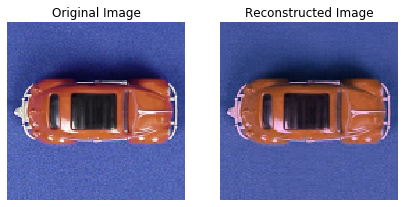

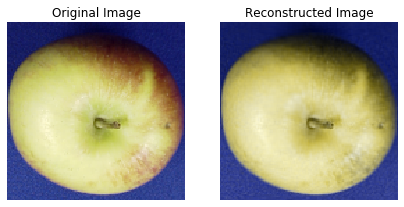

In [12]:
# Evaluate results

# ================================================================================
# For image of car
# ================================================================================
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm

print("Relative error of approximation for Car image = {}".format(rel_error_car))
# Reconstruction
tensor_rec_car = tensor_tkd_car.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_car, tensor_rec_car)

# ================================================================================
# For image of apple
# ================================================================================
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm

print("Relative error of approximation for Car image = {}".format(rel_error_apple))
# Reconstruction
tensor_rec_apple = tensor_tkd_apple.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_apple, tensor_rec_apple)

The original tensor images both are order-3 tensors with dimensions (128,128,3), thus for perfect reconstruction multi-linear rank must be (128,128,3). We are using the HOSVD to compute the Tucker form of the images using multi-linear rank of (50,50,2). The first two dimensions (modes) signify the Height (H) and Width (W) of images. Therefore, by using H=50 and W=50 instead of both being equal to 128, results in an apparent decrease in image "resolution" causing the reconstructed images to look more blurry than the original images, since we are losing details of images (however number of pixels remains the same). Originally, the images have three channels representing the Red-Blue-Green (RGB) colours and since their dimensions are (128,128,3), the original tensor images have 49152 elements, while the reconstructed images, have only 5000 elements. Even in the case that multi-linear rank is set to (50,50,3), the number of elements are 7500, so this multi-linear rank does not provide perfect reconstruction of images from their Tucker forms resulting in some approximation error. This is because $R_{1}=50$ and $R_{2}=50$ procide the best description of all grey-levels (intensities) in the Height and Width dimension respectively, using 50 elements. However, despite the approximation error, the main features in each image are maintained after reconstruction. For example, we can still identify the main components and shapes of the car and apple in the images, however sharp edges (higher constrast pixels) are being smoothed out. It is worth noting that by reducing values of H and W, the reconstructed images become more and more blurry, resulting in higher approximation error. Having  Additionally, by using a multi-linear rank of (50,50,2), i.e. using two colour channels instead of three, means that only the two most significant channels (colours), which best describe all colour information in the image, remain in the reconstructed images, while the lest significant channel (colour) is discarded. The most significant colour channels are the ones that are dominant in each image, i.e. the colour channels for which the are more pixels with high intensities for these speficic colour channels.

Considering the image of car, the dominant colours present in image are the base colours blue (for background of image) and red (for most of car parts), i.e. there are more pixels in which blue and red channel have higher intensities than for green channel. This therefore means that the Tucker form discards the green colour (green channel) in car image and maintains only red and blue colours. This can be seen from the fact that the white colour in original car image becomes a magenta colour in the reconstructed image. This is because the colour white is obtained when the three RGB channels have maximum intensity. For example if intensity is coded using normalised values from 0 to 1, then for white colour [R,G,B]=[1,1,1]. By therefore maintaining only the two most significant colours, Tucker representation effectively removes green channel and thus white colour now appears as [R,G,B]=[1,0,1], which is effectively colour magenta. All other colours however in image remain intact. It should be noted that using normalised intensities, black colour is represented as [R,G,B]=[0,0,0], thus even in the case that green channel is removed, black-coloured parts in image also remain intact. Considering the top-view image of the apple, on the other hand, the dominant colours are blue (for background) and yellow-green (most parts of apple), thus in this case the red channel is being discarded (assuming the image is composed of the three base colours red,green and blue). This effectively means that intensities in the red channel are set to 0 intensity. This is shown in the reconstructed image, where the parts of apple where red colour is dominant, approximately having [R,G,B]=[1,0,0], are replaced by approximately black-coloured pixels since now [R,G,B]=[0,0,0]. Additionally, any pixels with red and green colours being dominant on apple ([R,G,B]=[1,1,0]) are replaced by green colour only ([R,G,B]=[0,1,0]). Athough there are no white-coloured pixels, in that case white colour would have been replaced by cyan colour ([R,G,B]=[0,1,1]). 

Finally, despite the compression of original image, where number of pixels reduces by 9.83 times, the approximation error is only 5.0% for car image and 3.7% for apple image, which shows that Tucker decomposition is very important for data compression with relatively low errors. Finally, the error in car image is higher than apple image, which might be due to the fact that car image contains more sharp edges which are being smoothed out by reconstruction.

### Solution: Part 2

In [13]:
# Create tensors from apple images

# ================================================================================
# For top view
# ================================================================================
# Get data in form of a Tensor
apple_top = get_image(item="apple", view="top")
tensor_apple_top = Tensor(apple_top)

# ================================================================================
# For side view
# ================================================================================
# Get data in form of a Tensor
apple_side = get_image(item="apple", view="side")
tensor_apple_side = Tensor(apple_side)

In [14]:
# Perform decomposition

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
rank = (50, 50, 2)

# ================================================================================
# For top view
# ================================================================================
tensor_tkd_apple_top = algorithm.decompose(tensor_apple_top, rank)

# ================================================================================
# For image of apple
# ================================================================================
tensor_tkd_apple_side = algorithm.decompose(tensor_apple_side, rank)


Relative error of approximation for top-view Apple image = 0.03706225838740824
Relative error of approximation for side-view Apple image = 0.0657469040602635


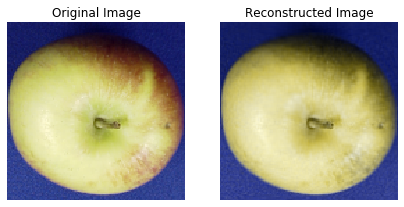

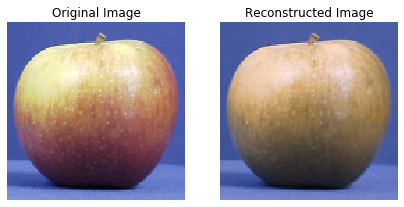

In [15]:
# Evaluate results

# ================================================================================
# For top view
# ================================================================================
tensor_res_apple_top = residual_tensor(tensor_apple_top, tensor_tkd_apple_top)
rel_error_apple_top = tensor_res_apple_top.frob_norm / tensor_apple_top.frob_norm

print("Relative error of approximation for top-view Apple image = {}".format(rel_error_apple_top))
# Reconstruction
tensor_rec_apple_top = tensor_tkd_apple_top.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_apple_top, tensor_rec_apple_top)

# ================================================================================
# For side view
# ================================================================================
tensor_res_apple_side = residual_tensor(tensor_apple_side, tensor_tkd_apple_side)
rel_error_apple_side = tensor_res_apple_side.frob_norm / tensor_apple_side.frob_norm

print("Relative error of approximation for side-view Apple image = {}".format(rel_error_apple_side))
# Reconstruction
tensor_rec_apple_side = tensor_tkd_apple_side.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_apple_side, tensor_rec_apple_side)


As mentioned in previous task, by using multi-linear rank equal to (50,50,2) we are effectively reducing image resolution (lower number of elements of reconstructed tensor) and only the two most significant channels are considered (the channels with highest variation in intensity that give lowest approximation error).

In the top view of apple image, the two dominant colours are blue and green therefore red channel is being discarded. Red colour is effectively removed by the image since the percentage of pixels with high intensity for blue and green colours are much higher than those for red colour. On the other hand, in the side-view image of the apple, the three colour channels are more balanced with similar percentages of pixels having high intensity for each colour. The algorithm finds the two most dominant colours to describe the whole image. These colours can be any two colours that can be represented in RGB (can be any colour not just the base colours red, green and blue) and become the basis colours in our reduced tensor space (like a colour pallete composed of two colours). The two most significant colour in the background of image is the blue colour, while the colour that best describes the apple is a mixture of green and red colour resulting in the colour brown. Therefore, when the picture is reconstructed, the background has the colour blue (as before) and the apple itself becomes brown.

It should be noted that this also occurs in top-view image, however in that case since the colours of the apple are less balanced, the colour that best describes the apple is the yellow-green colour. 

The effect of mixing red and green channels in side-view instead of discarding one of the two channels, to have only basis colours, results in high approximation error (6.7%), which is approximately twice (1.81 times) of that obtained in the top-view apple image (3.7%). This means that the more balanced an image is in terms of colour percentages, the higher the approximation error obtained from dimensionality reduction due to mixing of colours occuring in the reduced tensor space.

### Solution: Part 3

By setting the value of multi-linear rank correponding to the channel model equal to 1, the reconstructed image will contain only different intensities (shades) of a single colour. This is because the image is now transformed from a tensor to a matrix (2D structure). The colour used will be the one that minimises the approximation error due to Tucker decomposition, which is effectively leaves us with only a single vector to describe all colour information. This, as expected, will be insufficient to model all colour variations in the original image, but will be the best approximation possible. In the case that the percentage of most dominant colour is much higher than all colours present in the image, the reconstructed image will be entirely composed of this colour. In the case, however, that the percentages colours are more balanced, then the output colour will be a mixture of all these colours that will best describe the original image, with least error.

An illustration is provided below to show the results of using a multi-linear rank of (50,50,1) on the side-view image of car and the side-view image of apple. As we can see, both reconstructed images are composed of only a single colour. For the side-view image of car, since the blue colour in the background is the dominant colour (car itself is much smaller in size compared to background), the reconstructed image is composed of shades (different intensities) of blue colour only. For the side-view image of the apple, the colours are more balanced and the output image has a single colour (red-brown) which is a mixture of the dominant colours in the image. Again, the highest error occurs when percentage of colours is more balanced (19.3% for car and 22.5% for apple). 

Relative error of approximation for Car image = 0.1928310530144666
Relative error of approximation for Apple image = 0.22511914105500594


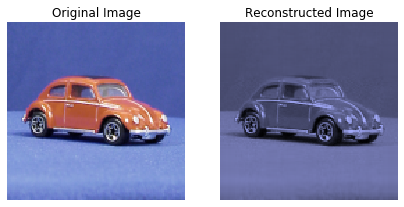

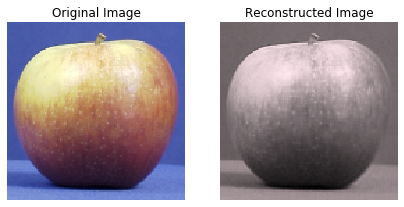

In [16]:
# Illustration - Considering for example side-view of car image and apple image

# Create tensors from car image
car = get_image(item="car", view="side")
# Create tensors from apple image
apple = get_image(item="apple", view="side")
# Get data in form of a Tensor
tensor_car = Tensor(car)
tensor_apple = Tensor(apple)

# Perform decomposition
# Initialise algorithm and preform decomposition
algorithm = HOSVD()
rank = (50, 50, 1)
tensor_tkd_car = algorithm.decompose(tensor_car, rank)
tensor_tkd_apple = algorithm.decompose(tensor_apple, rank)

# Evaluate results
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm
print("Relative error of approximation for Car image = {}".format(rel_error_car))
# Reconstruction
tensor_rec_car = tensor_tkd_car.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensor_car, tensor_rec_car)
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm
print("Relative error of approximation for Apple image = {}".format(rel_error_apple))
# Reconstruction
tensor_rec_apple = tensor_tkd_apple.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensor_apple, tensor_rec_apple)